# Prototype Neural Networks for Estimating Turbofan Engine Failure

## Background

This notebook contains the final prototype neural networks that attempt to estimate the remaining number of cycles in a turbofan engine in order to aid with the prediction of prevantative maintenance. The dataset is taken from a NASA simulation that simulated various different turbofans over a number of cycles until they failed some efficiency criteria. The simulation provides readings of sensors throughout the engine, the readings of which change as engine health degrades and can be used to make the prediction. In the dataset, there are 100 unique engines, each with their own starting "health," thus leading to differing numbers of cycles until failure for each engine ID. 

## Methodology



In [51]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score,mean_squared_error
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

In [2]:
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 'T2', 'T24'
             , 'T30', 'T50','P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30'
             , 'phi', 'NRf', 'NRc', 'BPR','farB', 'htBleed', 'Nf_dmd',
             'PCNfR_dmd','W31', 'W32', 's22', 's23']

Import the training, test, and remaining useful life data and remove all NaN values.

In [194]:
train = pd.read_csv("train.txt", sep=' ', names=col_names)
test = pd.read_csv("test.txt", sep=' ', names=col_names)
RUL = pd.read_csv("RUL.txt", sep=' ', names=['remaining_cycles', 'Nan'])
RUL.head()

,remaining_cycles,Nan
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [195]:
train.drop(columns=['s22', 's23'], axis=1, inplace=True)
test.drop(columns=['s22', 's23'], axis=1, inplace=True)
RUL.drop(columns=['Nan'], axis=1, inplace=True)

In [196]:
RUL['id'] = RUL.index + 1

RUL.head()

,remaining_cycles,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


The dataset is made up of sensor data for 100 different engines, as can be seen below.

In [197]:
print('Engine IDs:', train.id.unique())

Engine IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


## Processing Data

A testing dataset is provided where the engines are not ran until failure, and a complimentary vector is provided for the remaining useful life (RUL) for each engine ID. In order to match the engines in the test set with their corresponding RUL, we must concatenate the two datasets.

Since the engines in the test set are ran until failure, you can calculate the remaining cycles until failure by subtracting the current cycle from the maximum cycle for each engine ID. He does this for the test set as well. Since the remaining useful life for all the test engines are given, as well as their current cycle, the maximum cycles for each engine can be calculated.

In [198]:
train['remaining_cycles'] = train.groupby(['id'])['cycle'].transform(max)-train['cycle']

In [199]:
train

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,remaining_cycles
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [200]:
# Maximum cycles = cycles at test end + remaining useful life

maxCycles = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
maxCycles.columns = ['id', 'max_tested']
maxCycles['max_cycles'] = RUL['remaining_cycles'] + maxCycles['max_tested']
maxCycles.drop(['max_tested'], axis=1, inplace=True)

In [201]:
maxCycles.head()

,id,max_cycles
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [202]:
test = test.merge(maxCycles, on=['id'], how='left')

In [203]:
test['remaining_cycles'] = test['max_cycles'] - test['cycle']
test.drop(['max_cycles'], axis=1, inplace=True)

Removing extraneous variables that hurt modeling

In [204]:
X = train.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles'], axis=1)

In [205]:
y = train.remaining_cycles

In [206]:
X.head()

,setting1,setting2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
0,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [207]:
y.head()

0    191
1    190
2    189
3    188
4    187
Name: remaining_cycles, dtype: int64

Many iterations were done with the data being unshuffled, to poor results. The unshuffled data causes the series to be split in the middle of an engines cycle count which lead to poor learning and drastic overfitting of the training data. Shuffling the data lead to greatly improved training and test results for the fully connected net.

In [208]:
train_shuffled = train.sample(frac=1)
X = train_shuffled.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles'], axis=1)
y = train_shuffled.remaining_cycles

In [209]:
X_test = test.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles'], axis=1)
y_test = test.remaining_cycles

## Fully Connected Sequential Net


Scaling the data to be between 0 and 1. Since all the sensors measure different physical quantities, they have different orders of magnitude. This will scale everything to the same order of magnitude.

In [31]:
from sklearn.preprocessing import MinMaxScaler
gen = MinMaxScaler(feature_range=(0,1))
X = gen.fit_transform(X)
X = pd.DataFrame(X)
X = np.nan_to_num(X)

X = np.array(X)

### Create a function to make models

The model below is the result of many different iterations and trial and error tests. During development, many different parameters were changed and tuned in order to get a good performing model, such as the number of layers, neurons per layer, activation type, different types of normalization between layers, different optimizers, and the inclusion of a dropout layer.

The best results were found to be with 6 layers, starting with 512 neurons in the first layer, with batch normalization between each layer except the last. Sigmoid activation was used as it prevents negative values from passing between layers as it scales everything from 0 to 1, and a dropout layer with rate 0.2 was added to aid with overfitting.

Compared to the first iteration of this model, which had only 3 layers starting with 128 neurons, no normalization, no dropout, and relu activation types, this model performs considerably better in terms of loss and overfitting.

In [32]:
def make_model(loss_type, activation_type):
    model = keras.Sequential([keras.Input(shape=(16,)),
                              layers.Dense(512, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(256, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(128, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(64, activation=activation_type),
                              layers.Dropout(0.2),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(16, activation=activation_type),
                              layers.Dense(1)])
    model.compile(loss=loss_type, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics='accuracy')
    return model
    

In [39]:
tf.keras.backend.clear_session()
dnn = make_model('mean_squared_error', 'sigmoid')
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               8704      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

300 epochs was chosen as the stopping point as any higher value lead to the model quickly and drastically overfitting the training set. This number lead to the lowest loss on the test set as well.

In [40]:
%%time
history = dnn.fit(X, y, validation_split=(1-(len(train)-(len(train)-16739))/len(train)), verbose=1, epochs=300)

Epoch 1/300
524/524 [==============================] - 2s 2ms/step - loss: 15396.8311 - accuracy: 0.0046 - val_loss: 14745.4717 - val_accuracy: 0.0039
Epoch 2/300
524/524 [==============================] - 1s 2ms/step - loss: 14097.2354 - accuracy: 0.0048 - val_loss: 13591.6445 - val_accuracy: 0.0051
Epoch 3/300
524/524 [==============================] - 1s 2ms/step - loss: 12871.7207 - accuracy: 0.0049 - val_loss: 12392.2461 - val_accuracy: 0.0039
Epoch 4/300
524/524 [==============================] - 1s 2ms/step - loss: 11780.6094 - accuracy: 0.0051 - val_loss: 11368.4336 - val_accuracy: 0.0039
Epoch 5/300
524/524 [==============================] - 1s 2ms/step - loss: 10811.7471 - accuracy: 0.0051 - val_loss: 10451.0342 - val_accuracy: 0.0039
Epoch 6/300
524/524 [==============================] - 1s 2ms/step - loss: 9925.7520 - accuracy: 0.0051 - val_loss: 9585.9619 - val_accuracy: 0.0039
Epoch 7/300
524/524 [==============================] - 1s 2ms/step - loss: 9106.8740 - accuracy:

524/524 [==============================] - 1s 2ms/step - loss: 1775.6935 - accuracy: 0.0051 - val_loss: 1728.5597 - val_accuracy: 0.0039
Epoch 56/300
524/524 [==============================] - 1s 2ms/step - loss: 1783.2747 - accuracy: 0.0051 - val_loss: 1799.5795 - val_accuracy: 0.0039
Epoch 57/300
524/524 [==============================] - 1s 2ms/step - loss: 1786.1742 - accuracy: 0.0051 - val_loss: 1729.9540 - val_accuracy: 0.0039
Epoch 58/300
524/524 [==============================] - 1s 2ms/step - loss: 1773.9122 - accuracy: 0.0051 - val_loss: 1780.3196 - val_accuracy: 0.0039
Epoch 59/300
524/524 [==============================] - 1s 2ms/step - loss: 1775.8776 - accuracy: 0.0051 - val_loss: 1833.0336 - val_accuracy: 0.0039
Epoch 60/300
524/524 [==============================] - 1s 2ms/step - loss: 1755.2264 - accuracy: 0.0051 - val_loss: 1715.7992 - val_accuracy: 0.0039
Epoch 61/300
524/524 [==============================] - 1s 2ms/step - loss: 1758.1517 - accuracy: 0.0051 - val_lo

524/524 [==============================] - 1s 2ms/step - loss: 1738.6250 - accuracy: 0.0051 - val_loss: 1740.8134 - val_accuracy: 0.0039
Epoch 110/300
524/524 [==============================] - 1s 2ms/step - loss: 1738.4258 - accuracy: 0.0051 - val_loss: 1748.9528 - val_accuracy: 0.0039
Epoch 111/300
524/524 [==============================] - 1s 2ms/step - loss: 1746.0806 - accuracy: 0.0051 - val_loss: 1709.7889 - val_accuracy: 0.0039
Epoch 112/300
524/524 [==============================] - 1s 2ms/step - loss: 1737.0864 - accuracy: 0.0051 - val_loss: 1712.2643 - val_accuracy: 0.0039
Epoch 113/300
524/524 [==============================] - 1s 2ms/step - loss: 1735.7883 - accuracy: 0.0051 - val_loss: 1724.0864 - val_accuracy: 0.0039
Epoch 114/300
524/524 [==============================] - 1s 2ms/step - loss: 1750.7360 - accuracy: 0.0051 - val_loss: 1752.3060 - val_accuracy: 0.0039
Epoch 115/300
524/524 [==============================] - 1s 2ms/step - loss: 1739.2512 - accuracy: 0.0051 - 

524/524 [==============================] - 1s 2ms/step - loss: 1721.3519 - accuracy: 0.0051 - val_loss: 1715.2697 - val_accuracy: 0.0039
Epoch 164/300
524/524 [==============================] - 1s 2ms/step - loss: 1710.4989 - accuracy: 0.0051 - val_loss: 1713.9871 - val_accuracy: 0.0039
Epoch 165/300
524/524 [==============================] - 1s 2ms/step - loss: 1711.4175 - accuracy: 0.0051 - val_loss: 1699.7776 - val_accuracy: 0.0039
Epoch 166/300
524/524 [==============================] - 1s 2ms/step - loss: 1722.3750 - accuracy: 0.0051 - val_loss: 1715.1531 - val_accuracy: 0.0039
Epoch 167/300
524/524 [==============================] - 1s 2ms/step - loss: 1702.6318 - accuracy: 0.0051 - val_loss: 1727.8771 - val_accuracy: 0.0039
Epoch 168/300
524/524 [==============================] - 1s 2ms/step - loss: 1722.9932 - accuracy: 0.0051 - val_loss: 1732.2179 - val_accuracy: 0.0039
Epoch 169/300
524/524 [==============================] - 1s 2ms/step - loss: 1713.3591 - accuracy: 0.0051 - 

524/524 [==============================] - 1s 2ms/step - loss: 1693.7505 - accuracy: 0.0051 - val_loss: 1738.1849 - val_accuracy: 0.0039
Epoch 218/300
524/524 [==============================] - 1s 2ms/step - loss: 1684.5330 - accuracy: 0.0051 - val_loss: 1799.3325 - val_accuracy: 0.0039
Epoch 219/300
524/524 [==============================] - 1s 2ms/step - loss: 1691.8850 - accuracy: 0.0051 - val_loss: 1721.0370 - val_accuracy: 0.0039
Epoch 220/300
524/524 [==============================] - 1s 2ms/step - loss: 1699.8486 - accuracy: 0.0051 - val_loss: 1739.9432 - val_accuracy: 0.0039
Epoch 221/300
524/524 [==============================] - 1s 2ms/step - loss: 1690.3667 - accuracy: 0.0051 - val_loss: 1738.7605 - val_accuracy: 0.0039
Epoch 222/300
524/524 [==============================] - 1s 2ms/step - loss: 1684.9458 - accuracy: 0.0051 - val_loss: 1754.7662 - val_accuracy: 0.0039
Epoch 223/300
524/524 [==============================] - 1s 2ms/step - loss: 1701.9432 - accuracy: 0.0051 - 

524/524 [==============================] - 1s 2ms/step - loss: 1666.9302 - accuracy: 0.0051 - val_loss: 1723.9086 - val_accuracy: 0.0039
Epoch 272/300
524/524 [==============================] - 1s 2ms/step - loss: 1658.9155 - accuracy: 0.0051 - val_loss: 1754.1858 - val_accuracy: 0.0039
Epoch 273/300
524/524 [==============================] - 1s 2ms/step - loss: 1652.8254 - accuracy: 0.0051 - val_loss: 1728.0973 - val_accuracy: 0.0039
Epoch 274/300
524/524 [==============================] - 1s 2ms/step - loss: 1665.7224 - accuracy: 0.0051 - val_loss: 1740.5469 - val_accuracy: 0.0039
Epoch 275/300
524/524 [==============================] - 1s 2ms/step - loss: 1677.2457 - accuracy: 0.0051 - val_loss: 1732.3329 - val_accuracy: 0.0039
Epoch 276/300
524/524 [==============================] - 1s 2ms/step - loss: 1668.4507 - accuracy: 0.0051 - val_loss: 1721.0736 - val_accuracy: 0.0039
Epoch 277/300
524/524 [==============================] - 1s 2ms/step - loss: 1673.8500 - accuracy: 0.0051 - 

In [28]:
def plot_loss(fit):
    plt.figure(figsize=(16,9))
    plt.plot(fit.history['loss'], label='loss')
    plt.plot(fit.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Remaining Cycles Error')
    plt.legend(loc=0, prop={'size':26})
    plt.grid(True)
    plt.show()

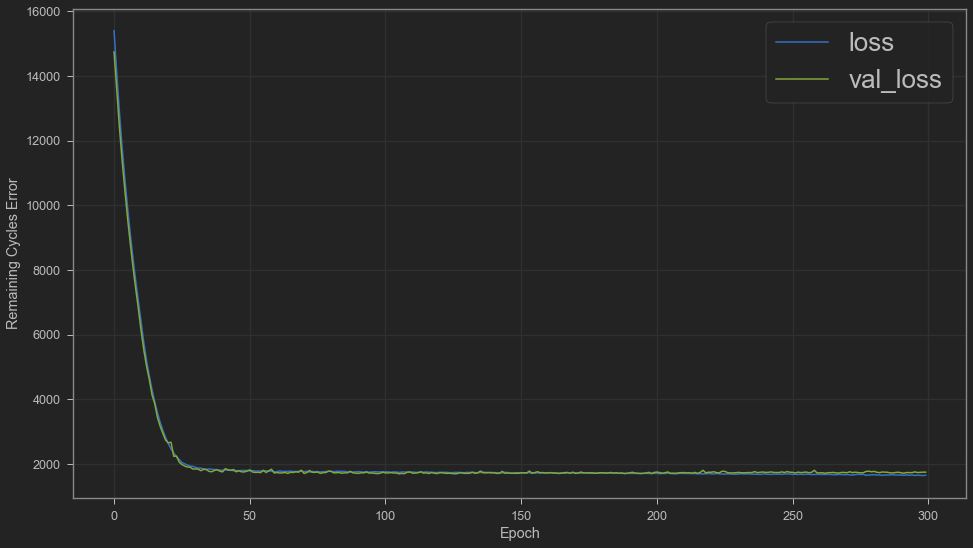

In [52]:
plot_loss(history)

In [37]:
gen2 = MinMaxScaler(feature_range=(0,1))
X_test = gen2.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
X_test = np.nan_to_num(X_test)

X_test = np.array(X_test)

In [42]:
dnn.evaluate(X_test, y_test, verbose=1)

410/410 [==============================] - 0s 639us/step - loss: 8926.4531 - accuracy: 0.0000e+00


[8926.453125, 0.0]

In [43]:
def plot_accuracy(fit):
    plt.figure(figsize=(16,9))
    plt.plot(fit.history['accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

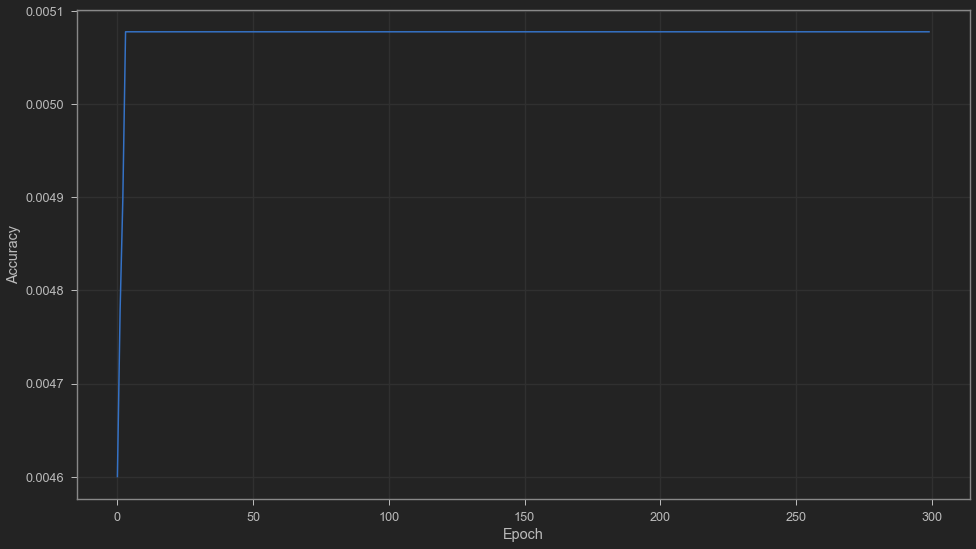

In [53]:
plot_accuracy(history)

Making predictions with the model. Note that the test data has been scaled from 0 to 1 but not shuffled.

In [45]:
pred = dnn.predict(X_test)
pred = np.reshape(pred, -1)

As we can see, the model predictions do not exactly match the test dataset. However, the model does seem to underpredict the amount of remaining cycles on average, which is good from a safety standpoint. The magnitude and distribution of the predictions seem to both be smaller than that of the test data.

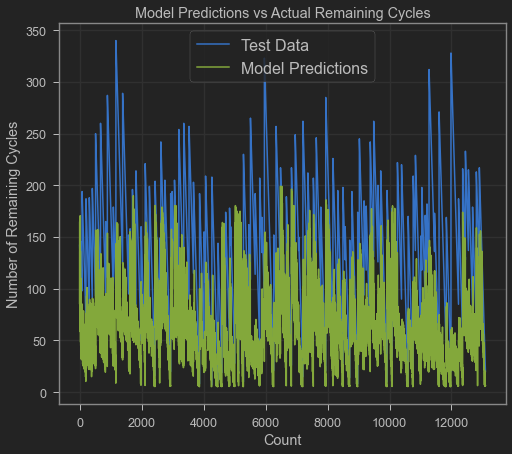

In [56]:
plt.figure()
plt.plot(y_test, label='Test Data')
plt.plot(pred, label='Model Predictions')
plt.xlabel('Count')
plt.ylabel('Number of Remaining Cycles')
plt.title('Model Predictions vs Actual Remaining Cycles')
plt.legend(loc=0, prop={'size':16})
plt.show()

In [58]:
print(f"R^2 is {r2_score(y_test, pred)}")

R^2 is -1.5662618662941417


### LSTM Model

Since the dataset is timeseries data, a LSTM model was also created in order to try and improve performance. To tailor the data to a LSTM, the dataset must be broken up into "chunks" or windows containing a certain amount of time-related data, then the chunks are shuffled and fed into the net.

In [184]:
X = train.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles'], axis=1)
y = train.remaining_cycles

In [185]:
gen3 = MinMaxScaler(feature_range=(0,1))
X = gen3.fit_transform(X)
X = pd.DataFrame(X)
X = np.nan_to_num(X)

X = np.array(X)

Split the data into windows of size 6

In [186]:
AR = 10

def create_dataset(X, AR=AR):
    data = []
    for i in range(len(X)-AR-1):
        data.append(X[i:(i+AR)])
    return np.array(data)

In [187]:
X = create_dataset(X, AR)
y_train = y[AR+1:]

In [188]:
def lstm_model(data_in):
    model = keras.Sequential()
    model.add(layers.LSTM(256, input_shape=(data_in[1], data_in[0]), activation='sigmoid', 
                          return_sequences=True))
    model.add(layers.BatchNormalization(axis=1))
    model.add(layers.LSTM(128, input_shape=(data_in[1], data_in[0]), activation='sigmoid', 
                          return_sequences=True))
    model.add(layers.BatchNormalization(axis=1))
    model.add(layers.LSTM(64, input_shape=(data_in[1], data_in[0]), activation='sigmoid',
                          return_sequences=False))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization(axis=1))
    model.add(layers.Dense(16, kernel_initializer='uniform', activation='sigmoid'))
    model.add(layers.Dense(1, kernel_initializer='uniform'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [189]:
tf.keras.backend.clear_session()
model = lstm_model([X.shape[2], X.shape[1]])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           279552    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 256)           40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128)           40        
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

In [192]:
history = model.fit(X, y, epochs=75, validation_split=0.2, verbose=1)

Epoch 1/50
516/516 [==============================] - 8s 16ms/step - loss: 2076.2358 - val_loss: 3827.6523
Epoch 2/50
516/516 [==============================] - 8s 15ms/step - loss: 1887.7710 - val_loss: 3756.2195
Epoch 3/50
516/516 [==============================] - 8s 16ms/step - loss: 1750.9670 - val_loss: 3612.3950
Epoch 4/50
516/516 [==============================] - 9s 17ms/step - loss: 1634.2405 - val_loss: 3030.7676
Epoch 5/50
516/516 [==============================] - 9s 17ms/step - loss: 1543.1859 - val_loss: 2864.0933
Epoch 6/50
516/516 [==============================] - 9s 17ms/step - loss: 1484.0173 - val_loss: 2788.0833
Epoch 7/50
516/516 [==============================] - 8s 16ms/step - loss: 1429.7209 - val_loss: 3121.0229
Epoch 8/50
516/516 [==============================] - 8s 16ms/step - loss: 1399.0682 - val_loss: 2574.7441
Epoch 9/50
516/516 [==============================] - 8s 16ms/step - loss: 1369.2595 - val_loss: 3605.6807
Epoch 10/50
516/516 [================

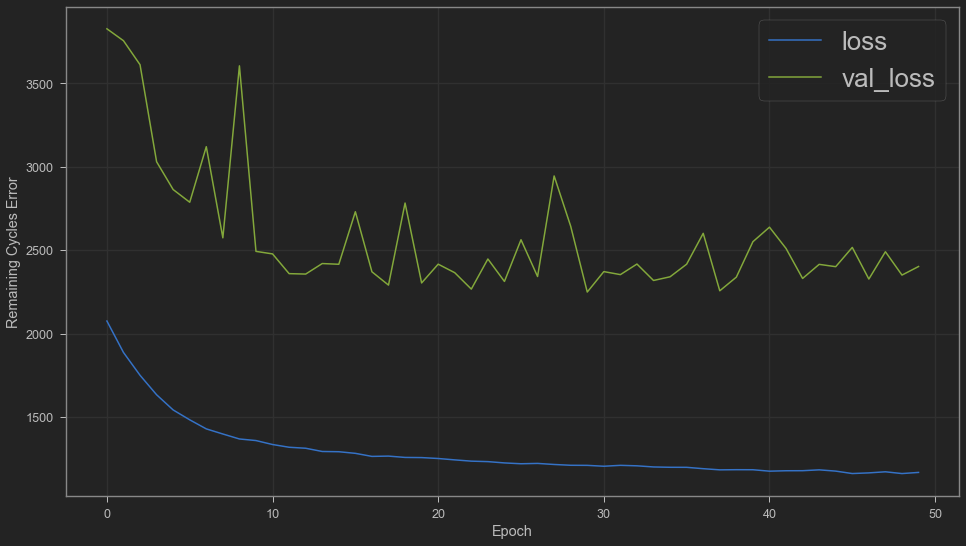

In [217]:
plot_loss(history)

In [210]:
X_test = test.drop(['id', 'cycle', 'setting3', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd',
                'remaining_cycles'], axis=1)
y_test = test.remaining_cycles

In [211]:
gen = MinMaxScaler(feature_range=(0,1))
X_test = gen.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
X_test = np.nan_to_num(X_test)

In [213]:
X_test = create_dataset(X_test, AR)
y_test = y_test[AR+1:]

In [214]:
model.evaluate(X_test, y_test, verbose=1)

409/409 [==============================] - 3s 6ms/step - loss: 8067.8525


8067.8525390625

In [215]:
pred = model.predict(X_test)
pred = np.reshape(pred, -1)

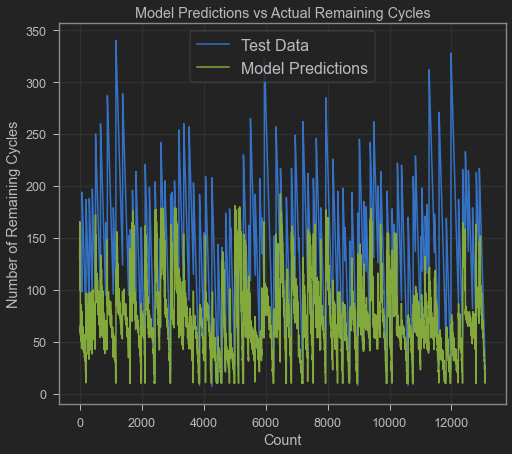

In [216]:
plt.figure()
plt.plot(y_test, label='Test Data')
plt.plot(pred, label='Model Predictions')
plt.xlabel('Count')
plt.ylabel('Number of Remaining Cycles')
plt.title('Model Predictions vs Actual Remaining Cycles')
plt.legend(loc=0, prop={'size':16})
plt.show()

In [218]:
print(f"R^2 is {r2_score(y_test, pred)}")

R^2 is -1.3174900859561283
